# Segmentation of mammo tiles

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
from fastai.core import *
from fastai import *
from fastai.vision import *
import PIL

from pathlib import *
import pandas as pd
import numpy as np
import colorcet as cc

from gray_image import *

cmap_grey = cc.cm.linear_grey_0_100_c0

In [41]:
path  = Path('../../data/mammography-data/mammography-dogscats-match-equalization-BINS-CHX/tiles')
#path  = Path("../../Dropbox/mammography-data/equalized2dg_tiles")
print(list(path.iterdir()))
xrays = "xrays"
masks = "masks"
train = "train"
valid = "test"

[PosixPath('../../data/mammography-data/mammography-dogscats-match-equalization-BINS-CHX/tiles/tvData.csv'), PosixPath('../../data/mammography-data/mammography-dogscats-match-equalization-BINS-CHX/tiles/test'), PosixPath('../../data/mammography-data/mammography-dogscats-match-equalization-BINS-CHX/tiles/train'), PosixPath('../../data/mammography-data/mammography-dogscats-match-equalization-BINS-CHX/tiles/tiles.csv')]


In [50]:
from enum import Enum
class ObsType(Enum):
    EMPTY=0           ,"empty"                   # outside the breast
    NORMAL=1          ,"normal"                  # tissue with no segments
    BENIGN_CALC=2     ,"benign_calcification"    # tissue with benign calcification
    MALIGNANT_CALC=3  ,"malignant calcification"  # tissue with malignant calcification
    BENIGN_MASS=4     ,"benign_mass"              # tissue with a benign node
    MALIGNANT_MASS=5  ,"malignant mass"           # tissue with a malignant node
def enum2int(e): return e.value[0]

def selectCases( cases, purpose, complexity, nb=1000 ): 
    dfAll = None
    for k,q in complexity.items():
        df  = cases[cases.purpose==purpose].query(q)
        df["classes"] = k
        idx   = np.unique(np.random.uniform( low=0, high=df.shape[0], size=10*nb).astype(int))
        idx   = idx[0:min(df.shape[0], nb, len(idx) )]
        dfAll = dfAll.append(df.iloc[idx]) if dfAll is not None else df.iloc[idx]
    return dfAll


In [36]:
cases = pd.read_csv( path / "tiles.csv", sep=";", low_memory=False)
print(f"cases.columns:{cases.columns}")
cases.drop("Unnamed: 0",axis=1,inplace=True)
display(cases.tail(2))

gp = cases.groupby( ["purpose", "simple_pathology", "observation"])["fnImage"].count()
print( gp )


cases.columns:Index(['Unnamed: 0', 'case_id', 'height', 'width', 'simple_pathology',
       'patient_id', 'purpose', 'density', 'left_right', 'projection',
       'obs id', 'observation', 'obs_shape', 'obs_distribution', 'assessment',
       'pathology', 'subtlety', 'tile_id', 'empty', 'normal', 'benign_calc',
       'malignant_calc', 'benign_mass', 'malignant_mass', 'rCenter', 'cCenter',
       'tile_size', 'obsAreas', 'fnImage', 'fnMask'],
      dtype='object')


,case_id,height,width,simple_pathology,patient_id,purpose,density,left_right,projection,obs id,...,benign_calc,malignant_calc,benign_mass,malignant_mass,rCenter,cCenter,tile_size,obsAreas,fnImage,fnMask
15746,Mass-Training_P_02092_LEFT_MLO,4877,2755,MALIGNANT,P_02092,train,0.0,LEFT,MLO,1,...,0,0,0,0,0.61,0.75,1048576,10824859,Mass-Training_P_02092_LEFT_MLO_tile_2469_1542.png,Mass-Training_P_02092_LEFT_MLO_tile_2469_1542.png
15747,Mass-Training_P_02092_LEFT_MLO,4877,2755,MALIGNANT,P_02092,train,0.0,LEFT,MLO,1,...,0,0,0,0,0.48,0.80,1048576,10824859,Mass-Training_P_02092_LEFT_MLO_tile_1813_1686.png,Mass-Training_P_02092_LEFT_MLO_tile_1813_1686.png


purpose  simple_pathology            observation  
test     BENIGN                      calcification     771
                                     mass             1156
         BENIGN;MALIGNANT            calcification       8
                                     mass               12
         MALIGNANT                   calcification     572
                                     mass              814
train    BENIGN                      calcification    3451
                                     mass             3344
         BENIGN;MALIGNANT            calcification       6
                                     mass                9
         BENIGN;MALIGNANT;MALIGNANT  mass               14
         MALIGNANT                   calcification    2436
                                     mass             3130
         MALIGNANT;BENIGN            calcification      21
                                     mass                4
Name: fnImage, dtype: int64


In [37]:
complexity={
#            "pHealthy":"pAir==0 and pBenign==0 and pMalignant==0",
            "malignant_calc":"malignant_calc > 0.1*tile_size and benign_calc==0 and empty==0",
#            "malignant_calc":"malignant_calc > 0.1*tile_size and malignant_calc > 0.5*obsAreas and benign_calc==0 and empty==0",
#            "pAir":"pAir>0.2 and pAir<1.0", 
#            "benign_calc":"benign_calc/tile_size>0.1 and benign_calc > 0.5*obsAreas and malignant_calc==0 and empty==0"
            "benign_calc":"benign_calc/tile_size>0.1 and malignant_calc==0 and empty==0"
#            "pMalignant":"pMalignant > 0.99*obsAreas and pBenign==0 and pAir==0"
}
nb=100
#cases = cases[cases["abnormality type"]=="calcification"]
#display(cases["abnormality type"].tail(5))

test  = selectCases( cases, "test",     complexity=complexity, nb=nb//2 )
train = selectCases( cases, "train", complexity=complexity, nb=nb )
cases = train.append( test, ignore_index=False )
cases.reset_index(drop=True,inplace=True)

print(f"Total: {cases.shape[0]}")
gp = cases.groupby( ["purpose", "observation", "classes"])["fnImage"].count()
print( gp )

#generate training and validation csv for fastai
dfData = cases.loc[: , ["purpose", "classes", "fnImage", "fnMask" ]]
dfData.to_csv( path / "tvData.csv", index=False)
dfData.head(2)
cases=None

Total: 283
purpose  observation    classes       
test     calcification  benign_calc        33
                        malignant_calc     50
train    calcification  benign_calc       100
                        malignant_calc    100
Name: fnImage, dtype: int64


In [38]:
def open_mask_special( fn ): 
    a = PIL.Image.open( fn )
    a = (np.asarray(a)/127).astype(np.int)
    return ImageSegment( pil2tensor(a, np.float32 ))

purpose                                             test
classes                                      benign_calc
fnImage    Calc-Test_P_02153_RIGHT_MLO_tile_2836_643.png
fnMask     Calc-Test_P_02153_RIGHT_MLO_tile_2836_643.png
Name: 282, dtype: object

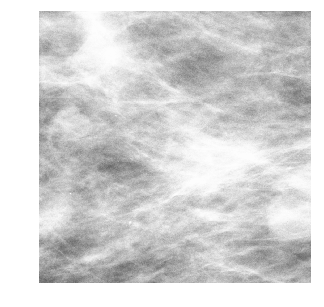

In [67]:
fnImage = path/valid/xrays/dfData.fnImage.iloc[0]
im=open_image_16bit2rgb(fnImage)
show_image( im, figsize=(5,5) )
dfData.iloc[-1]

In [69]:
fnMask = path/valid/masks/dfData.fnImage.iloc[0]
mask   = open_mask_special(fnMask)
mask.show(figsize=(5,5), cmap="tab20", alpha=.5)
np.max(mask.data.numpy())

TypeError: expected str, bytes or os.PathLike object, not list

In [49]:
print(mask.shape,mask.data)
print(mask.shape,mask.data.max())

torch.Size([1, 1024, 1024]) tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])
torch.Size([1, 1024, 1024]) tensor(0)


In [ ]:
EMPTY
    NORMAL=1          ,"normal"                  # tissue with no segments
    BENIGN_CALC=2     ,"benign_calcification"    # tissue with benign calcification
    MALIGNANT_CALC=3  ,"malignant calcification"  # tissue with malignant calcification
    BENIGN_MASS=4     ,"benign_mass"              # tissue with a benign node
    MALIGNANT_MASS

In [55]:
codes = [obs.name for obs in ObsType]
codes

['EMPTY',
 'NORMAL',
 'BENIGN_CALC',
 'MALIGNANT_CALC',
 'BENIGN_MASS',
 'MALIGNANT_MASS']

In [ ]:
ImageClassificationDataset
noTrainImages=100
trainIDs = np.arange(noTrainImages)


dsTrain  = SegmentationDataset(join_paths(dfData.fnImage[ixTrain].values, path/train/xrays), 
                               join_paths(dfData.fnImage[ixTrain].values, path/train/masks), 
                               codes)
dsValid  = SegmentationDataset(join_paths(dfData.fnImage[ixValid].values, path/valid/xrays), 
                               join_paths(dfData.fnImage[ixValid].values, path/valid/masks), 
                               codes)
dsTrain.image_opener = dsValid.image_opener = open_image_16bit2rgb
dsTrain.mask_opener  = dsValid.mask_opener  = open_mask_special


In [56]:
ixTrain  = dfData.purpose=="train"
ixValid  = ixTrain == False

dsTrain  = SegmentationDataset(join_paths(dfData.fnImage[ixTrain].values, path/train/xrays), 
                               join_paths(dfData.fnImage[ixTrain].values, path/train/masks), 
                               codes)
dsValid  = SegmentationDataset(join_paths(dfData.fnImage[ixValid].values, path/valid/xrays), 
                               join_paths(dfData.fnImage[ixValid].values, path/valid/masks), 
                               codes)
dsTrain.image_opener = dsValid.image_opener = open_image_16bit2rgb
dsTrain.mask_opener  = dsValid.mask_opener  = open_mask_special


In [58]:
def getSegmentationTransforms():
    max_zoom     = 1.1
    max_rotate   = 0.1
    max_lighting = 0 #0.2
    max_warp     = 0.01
    tfmTrain,tfmValid =[],[]
    #tfmTrain.append( rand_crop() )
    #tfmTrain.append( dihedral_affine() )
    
    #tfmTrain.append( flip_affine(p=0.5) )
    
    #tfmTrain.append( skew( np.arange, p=0.75) )
    #tfmTrain.append( symmetric_warp(magnitude=(-max_warp,max_warp), p=0.75) )
    #tfmTrain.append( perspective_warp(magnitude=(-max_warp,max_warp), p=0.75) )
    
    #tfmTrain.append( rotate(degrees=(-max_rotate,max_rotate), p=.25) )
    #tfmTrain.append( rand_zoom(scale=(1.,max_zoom), p=0.75) )

    #tfmTrain.append( jitter(magnitude=0.01) )
    tfmTrain.append(crop_pad())
    
    #if max_lighting > 0,:
    #    tfmTrain.append( brightness(change=(0.5*(1-max_lighting), 0.5*(1+max_lighting)), p=0.75) )
    #    tfmTrain.append( contrast(scale=(1-max_lighting, 1/(1-max_lighting)), p=p_lighting) )
    
    tfmValid.append(crop_pad())
    #tfmValid.append( flip_affine(p=0.5) )
    return (tfmTrain, tfmValid)

In [59]:
tfms       = getSegmentationTransforms()
dsTrainTfm = DatasetTfm(dsTrain, tfms[0], tfm_y=True)
dsValidTfm = DatasetTfm(dsValid, tfms[1], tfm_y=True)


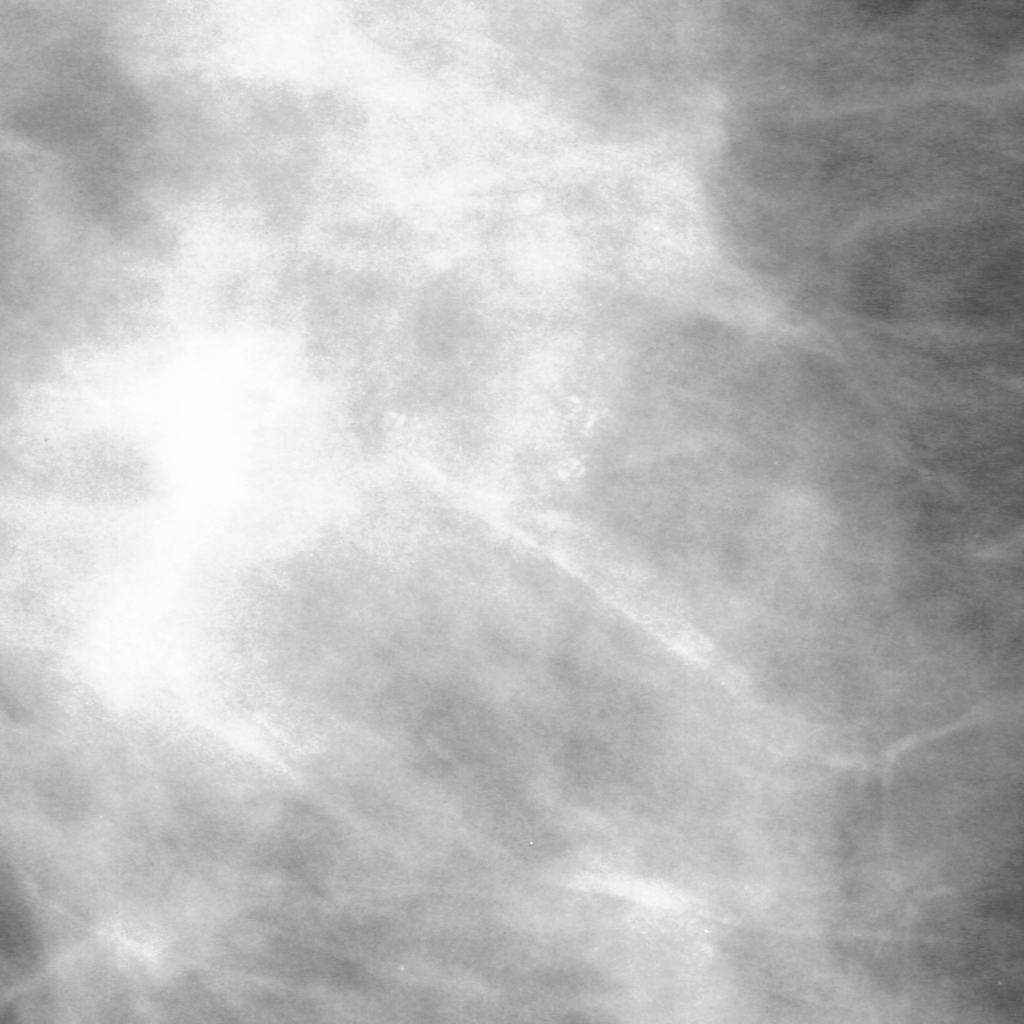

In [71]:
dsTrainTfm[0][0]

In [61]:
data = ImageDataBunch.create(dsTrainTfm, 
                             dsValidTfm, 
                             bs=8, 
                             size=224
                            )
data.normalize(imagenet_stats)

In [62]:
import matplotlib.gridspec as gridspec
def plotImageMaskMosaic( ims, masks ):
    nb    = len(ims)
    ncols = int(np.sqrt(nb))
    nrows = int(math.ceil(nb/ncols))

    fig = plt.figure(figsize=(16,24))

    gs = gridspec.GridSpec(nrows, ncols, height_ratios=np.zeros(nrows)+ 2, wspace=0.0, hspace=0.0)
    
    for i in range(nb):
        inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=gs[i], wspace=0.0, hspace=0.0)
        
        ax = plt.subplot(inner[0])
        ax.axis('off')
        ax.imshow(ims[i])

        ax = plt.subplot(inner[1])
        ax.axis('off')
        ax.imshow(masks[i])
    
    plt.show()

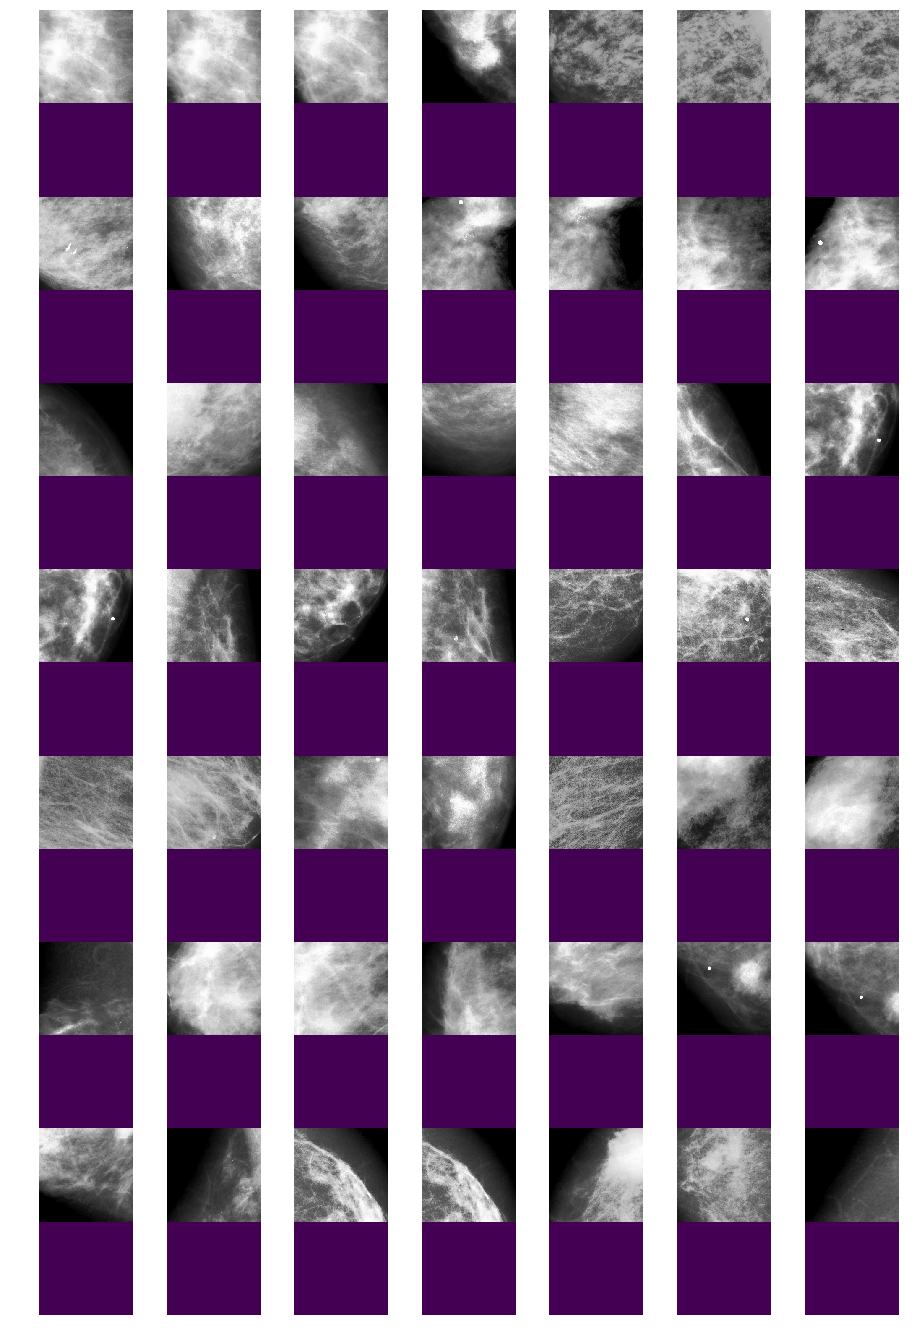

In [63]:
n=49
ims,masks = [],[]
for i in range(n):
    x,y = data.dl(DatasetType.Train).dataset[i]
    ims.append(   image2np(x.data) ) 
    masks.append( image2np(y.data) )
plotImageMaskMosaic(ims,masks)

In [26]:
print(data.classes)
len(data.classes),data.c

['normal', 'benign', 'malignant']


(3, 3)

In [27]:
void_code = 0

class Dummy:
    i=0
    inp = None
    tg = None
    
    @staticmethod
    def accuracy(input, target):
        if Dummy.i < 0:
            print(f"input.shape: {input.shape} - target.shape:{target.shape}")
            Dummy.i+=1
            Dummy.inp=input.cpu.data.numpy().copy()
            Dummy.tg = target.cpu.data.numpy().copy()
        
        
        target = target.squeeze()
        mask = target != void_code
        return (input.argmax(dim=1)[mask]==target[mask]).float().mean()
    

In [ ]:
learn = Learner.create_unet(data, models.resnet50, metrics=Dummy.accuracy)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


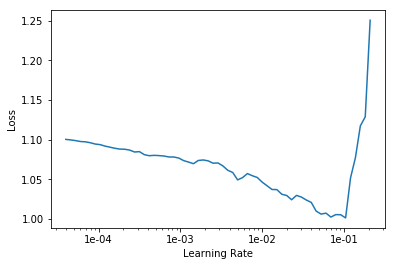

In [22]:
lr_find(learn, start_lr = 1e-05,end_lr=10.0 )
learn.recorder.plot()

In [23]:
lr_last_layer=0.005
learn.fit_one_cycle(3, max_lr=lr_last_layer)

Total time: 06:38
epoch  train_loss  valid_loss  accuracy
1      0.666295    0.780982    0.233612  (02:15)
2      0.623463    37.097626   0.298623  (02:11)
3      0.559849    294.830414  0.245087  (02:12)



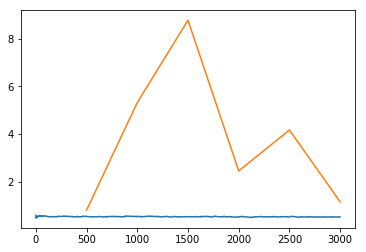

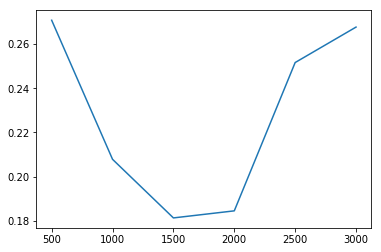

In [31]:
learn.recorder.plot_losses(), plt.show()
learn.recorder.plot_metrics()

In [25]:
learn.save('resnet34-stage-1')

In [26]:
learn.load('resnet34-stage-1')

Learner(data=<fastai.vision.data.ImageDataBunch object at 0x7fcb64202e48>, model=DynamicUnet(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(

meatadata for layer:  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
One image with all n filterweight with size  64 7 7


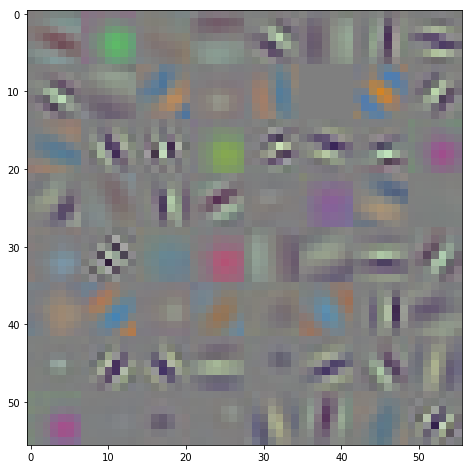

(56, 56, 3)

In [27]:
def plotTensor( im ):       
    colorMap = plt.cm.gray if im.ndim == 2 else None 
    
    fig = plt.figure(figsize=(8,8)) 
    plt.imshow(im, cmap=colorMap)    
    plt.show()
    
def createFilterImage( weights ) :   
    #scale to 0-1 and put the channel in the last as expect by matplotlib
    weights = 0.5*np.copy(weights+1.0)
    weights = np.rollaxis(weights, 1, 4)
    
    filter_dim = weights.shape[1]
    dim = int( 0.5+ np.sqrt( weights.shape[0] ) ) * filter_dim
    
    im = np.zeros([dim,dim,weights.shape[3]])
    for i in range(8):
        io = i*filter_dim
        for j in range(8):
            jo = j*filter_dim            
            i_filter = i*(filter_dim+1) + j
            #print( "\ni_filter: {}:  i_off: {} - {},  j_off: {} - {}",  i_filter, io, (io+filter_dim), jo,(jo+filter_dim) )
            im[io:(io+filter_dim), jo:(jo+filter_dim), :] = weights[i_filter,:,:,:]

    im = np.squeeze(im)        
    return im, filter_dim

def getLayers( model ): 
    layers=[]
    for g in list( model.children() ):
        layers.extend( list(g.children()) )
    return layers

def WeightsAsImage(model) :
    layers = getLayers(model)
    l      = layers[0]
    
    w = l.weight.data.cpu().numpy()
    im, filter_dim = createFilterImage(w)
    return im
    
def printWeight( model, i0=0, i1=1 ):
    layers = getLayers(model)
 
    for l in layers[i0:i1]:        
        print("meatadata for layer: ", l)
        w = l.weight.data.cpu().numpy()
        im, filter_dim = createFilterImage(w)
        print("One image with all n filterweight with size ", w.shape[0], filter_dim, filter_dim )
        #print("\nweights.shape :", w.shape, " - weights:\n", w)
        plotTensor(im)
    
printWeight(learn.model)

weightsBeforeUnfreeze =  WeightsAsImage(learn.model)
weightsBeforeUnfreeze.shape

In [28]:
#learn.unfreeze()

#unfreeze first layer
layers = getLayers(learn.model)
for param in layers[0].parameters():
    param.requires_grad = True

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


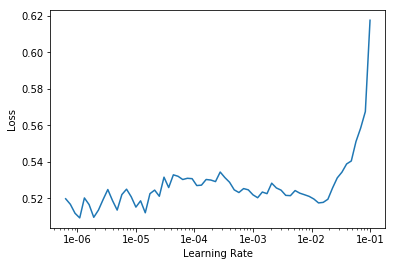

In [39]:
lr_find(learn )
learn.recorder.plot()

In [51]:
#learn.fit_one_cycle(6, slice(lr_last_layer*1e-4, lr_last_layer * 1e-1) )
learn.fit_one_cycle(12, slice(lr_last_layer*1e-2, lr_last_layer * 0) )

Total time: 25:43
epoch  train_loss  valid_loss  accuracy
1      0.513599    0.759425    0.285515  (02:08)
2      0.511577    0.843412    0.276032  (02:08)
3      0.507492    0.773200    0.273260  (02:08)
4      0.519217    1.107076    0.257116  (02:08)
5      0.505339    9.687095    0.299503  (02:08)
6      0.501760    1.148682    0.291435  (02:08)
7      0.502635    54.541252   0.281819  (02:08)
8      0.523078    2.712425    0.274691  (02:08)
9      0.498049    23.153498   0.313812  (02:08)
10     0.521717    1.236905    0.283002  (02:08)
11     0.503662    37.079464   0.300004  (02:08)
12     0.511610    9.129189    0.274569  (02:08)



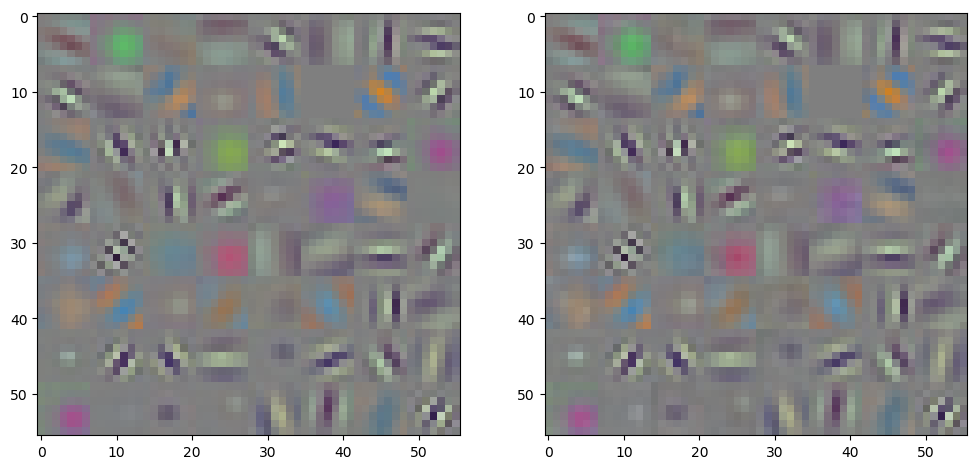

In [52]:
weightsAfterTrainingInputLayer = WeightsAsImage(learn.model)
fig,axes = plt.subplots(nrows=1, ncols=2, figsize =(12,12), dpi=100)
axes[0].imshow(weightsBeforeUnfreeze)  
axes[1].imshow(weightsAfterTrainingInputLayer)  

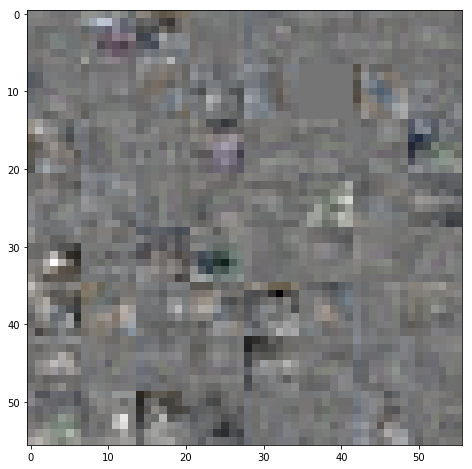

array([[[ 5.308807e-03,  6.037086e-03,  6.594539e-03],
        [ 7.154286e-03,  7.178664e-03,  7.355094e-03],
        [ 4.463375e-03,  4.003286e-03,  4.214168e-03],
        [-6.075799e-04, -1.070917e-03,  1.859665e-05],
        ...,
        [-9.639263e-04, -1.312554e-03, -2.037466e-03],
        [ 9.664893e-04,  7.076859e-04, -7.349253e-05],
        [ 1.157105e-03,  7.201433e-04,  1.595020e-04],
        [-4.135996e-03, -4.495561e-03, -4.768908e-03]],

       [[ 3.541231e-03,  3.644466e-03,  3.580838e-03],
        [ 5.009353e-03,  4.426241e-03,  3.864229e-03],
        [ 4.302382e-03,  3.243864e-03,  2.738297e-03],
        [ 2.969861e-03,  1.653790e-03,  1.950562e-03],
        ...,
        [-3.129810e-03, -3.255993e-03, -2.972931e-03],
        [-3.573895e-04, -1.521707e-04, -3.032088e-04],
        [-1.022130e-03, -8.951426e-04, -1.410007e-03],
        [-5.419821e-03, -5.538344e-03, -5.671442e-03]],

       [[-3.988743e-04,  4.246831e-04,  6.256998e-04],
        [-7.932305e-03, -7.171690e-

In [53]:
diff = weightsAfterTrainingInputLayer-weightsBeforeUnfreeze
diff = (diff-diff.min())/(diff.max()-diff.min())
plotTensor(diff)
weightsAfterTrainingInputLayer-weightsBeforeUnfreeze

In [ ]:
learn.load('resnet34-stage-2')

In [ ]:
learn.fit_one_cycle(12, slice(1e-5,lr_last_layer/5))

In [ ]:
learn.save('resnet34-stage-3')

In [ ]:
print(Dummy.i)
print(Dummy.inp.shape)
print(Dummy.tg.shape)

i=1
Image(tensor(Dummy.inp[i]))
Image(tensor(Dummy.tg[i]))
